In [3]:
from load_data import sim_arr

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split


# Split the data into train, test and validation sets
train_set, test_set = train_test_split(sim_arr, test_size=0.2, random_state=42)

print("Train set size: ", len(train_set),
      " Test set size: ", len(test_set))

Train set size:  2408  Test set size:  602


In [5]:
# check gpu
import tensorflow as tf
import os


print("Num GPUs Available: ", len(
    tf.config.experimental.list_physical_devices('GPU')))

os.environ['XLA_FLAGS'] = './cuda_sdk_lib/'

Num GPUs Available:  1


2024-04-10 13:04:32.052169: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 13:04:32.082662: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 13:04:32.082947: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
import optuna

from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from sklearn.model_selection import KFold, cross_val_score

# get input shape from the data
input_shape = train_set.shape[1:]
output_shape = (1, 1, 2)


def create_model(trial):
    # Hyperparameters to optimize
    num_layers = trial.suggest_int('num_layers', 1, 4)

    filters = [trial.suggest_int(f'filters_{i}', 1, 12)
               for i in range(num_layers - 1)] + [output_shape[-1]]

    activation = [trial.suggest_categorical(
        f'activation_{i}', ['relu', 'selu', 'tanh', 'sigmoid']) for i in range(num_layers)]

    initializer = [trial.suggest_categorical(
        f'initializer_{i}', ['lecun_normal', 'he_normal', 'he_uniform', 'glorot_normal', 'glorot_uniform']) for i in range(num_layers)]

    kernel_sizes = [trial.suggest_int(
        f'kernel_size{i}', 2, 24) for i in range(num_layers)]

    poolsize = [[16],
                [4, 4],
                [2, 2, 4],
                [2, 2, 2, 2]]

    # Encoder
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer(input_shape=input_shape))
    for i in range(num_layers):
        encoder.add(MaxPool2D(poolsize[num_layers - 1][i]))
        encoder.add(Conv2D(
            filters[i],
            kernel_sizes[i],
            strides=1,
            activation=activation[i],
            padding='same',
            kernel_initializer=initializer[i]
        ))
    encoder.add(MaxPool2D(5))

    # Decoder
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer(input_shape=encoder.output_shape[1:]))
    for i in range(num_layers - 1, -1, -1):
        decoder.add(Conv2DTranspose(
            filters[i],
            kernel_sizes[i],
            strides=poolsize[num_layers - 1][i],
            activation=activation[i],
            padding='same',
            kernel_initializer=initializer[i]
        ))
    decoder.add(Conv2DTranspose(
        input_shape[-1],
        kernel_sizes[0],
        strides=5,
        activation=activation[0],
        padding='same',
        kernel_initializer=initializer[0]
    ))

    # Compile the model
    auto_encoder = Sequential([encoder, decoder], name="autoencoder")
    auto_encoder.compile(optimizer='adam', loss="MSE")

    return auto_encoder


def objective(trial):
    # Clear clutter from previous sessions
    tf.keras.backend.clear_session()

    # Create model
    model = create_model(trial)

    # Train the model
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    val_losses = []
    for train_index, val_index in kf.split(train_set):
        X_train, X_val = train_set[train_index], train_set[val_index]
        history = model.fit(X_train, X_train, epochs=10, batch_size=32,
                            validation_data=(X_val, X_val))
        val_losses.append(history.history['val_loss'][-1])

    return np.mean(val_losses)


# Perform hyperparameter optimization
study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.HyperbandPruner(),
                            study_name='autoencoder_cv',
                            storage='sqlite:///test.db',
                            load_if_exists=True)
study.optimize(objective, n_trials=0)


# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)
print("Best value:", study.best_value)

[I 2024-04-10 13:04:32,650] Using an existing study with name 'autoencoder_cv' instead of creating a new one.


Best hyperparameters: {'num_layers': 4, 'filters_0': 7, 'filters_1': 10, 'filters_2': 12, 'activation_0': 'tanh', 'activation_1': 'tanh', 'activation_2': 'relu', 'activation_3': 'selu', 'initializer_0': 'lecun_normal', 'initializer_1': 'he_normal', 'initializer_2': 'he_uniform', 'initializer_3': 'he_uniform', 'kernel_size0': 17, 'kernel_size1': 10, 'kernel_size2': 22, 'kernel_size3': 24}
Best value: 0.004024394997395575


In [7]:
# Train the model with the best hyperparameters
auto_encoder = create_model(study.best_trial)

auto_encoder.fit(train_set, train_set, epochs=10, batch_size=32)
auto_encoder.evaluate(test_set, test_set)

/home/tux/optim/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2024-04-10 13:04:32.701076: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 13:04:32.701474: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 13:04:32.701735: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative val

Epoch 1/10


I0000 00:00:1712747075.035569  208431 service.cc:145] XLA service 0x7a4394026a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712747075.035614  208431 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 SUPER, Compute Capability 7.5
2024-04-10 13:04:35.114532: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 13:04:35.319013: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-04-10 13:04:35.864398: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-10 13:04:37.176695: W external/local_xla/xla/service/gpu/llvm_gpu_backend

 5/76 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2612

I0000 00:00:1712747078.614956  208431 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2076

2024-04-10 13:04:41.876712: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 0.2064
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0794
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0460
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0304
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0211
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0169
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0148
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0114
Epoch 9/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0110
Epoch 10/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0096
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0103

2024-04-10 13:05:10.363191: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0103


0.010009394958615303

In [8]:
# summarize the encoder and decoder architecture
auto_encoder.get_layer('encoder').summary()
auto_encoder.get_layer('decoder').summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 40, 40, 7)      │         6,076 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 7)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 10)     │         7,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 12)     │        58,092 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 2)        │        13,826 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 2)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,004 (332.05 KB)

 Trainable params: 85,004 (332.05 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (None, 2, 2, 2)        │         2,306 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 4, 4, 12)       │        11,628 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 8, 8, 10)       │        12,010 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 16, 16, 7)      │        20,237 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 80, 80, 3)      │         6,072 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,253 (204.11 KB)

 Trainable params: 52,253 (204.11 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], "-o", label="loss")
plt.plot(history.history["val_loss"], "-o", label="validation loss")
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid()
plt.show()

NameError: name 'history' is not defined

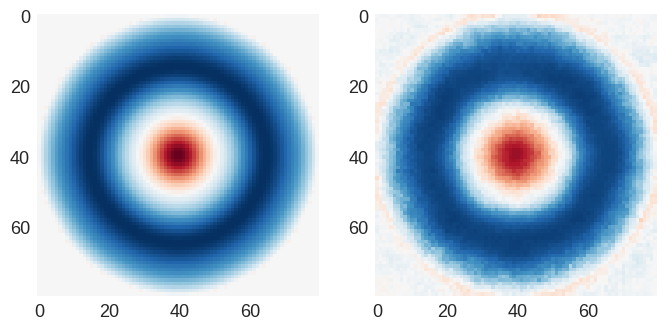

In [10]:
i = np.random.randint(0, len(test_set))
in_sim = test_set[i: i + 1]
out_sim = auto_encoder(in_sim)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(in_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")
ax[1].imshow(out_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")

In [11]:
from tensorflow.keras.layers import Flatten as Flatten

feature_extractor = Sequential(
    [
        auto_encoder.get_layer("encoder"),
        Flatten(),
    ]
)

feat_shape = auto_encoder.get_layer("encoder").output_shape[-1]

feature_arr = feature_extractor.predict(sim_arr, verbose=2)

2024-04-10 13:06:52.612182: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 231168000 exceeds 10% of free system memory.
2024-04-10 13:06:52.745131: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 231168000 exceeds 10% of free system memory.


95/95 - 1s - 9ms/step


In [12]:
# Save the feature array
np.save("feature_arr.npy", feature_arr)

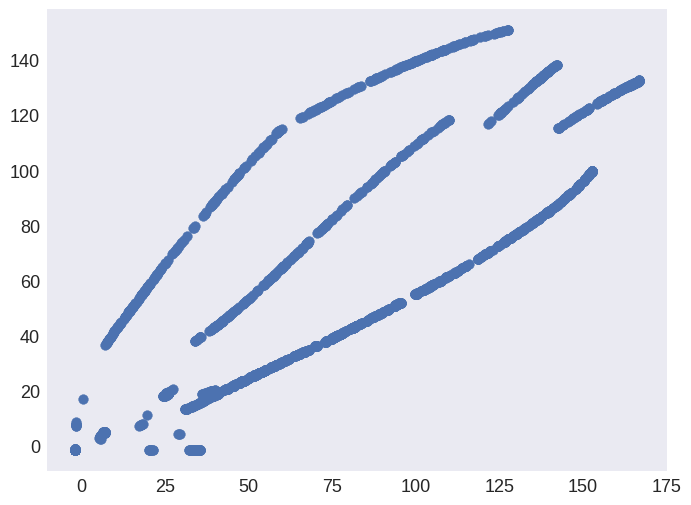

In [13]:
plt.scatter(feature_arr[:, 0], feature_arr[:, 1])

In [14]:
train_set.shape[1:]

(80, 80, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Reshape



# Define Clustering Layer
class ClusteringLayer(tf.keras.layers.Layer):
    def __init__(self, num_clusters, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.num_clusters = num_clusters

    def build(self, input_shape):
        self.clusters = self.add_weight(name='clusters',
                                        shape=(self.num_clusters,
                                               input_shape[1]),
                                        initializer='glorot_uniform',
                                        trainable=True)

    def call(self, inputs, **kwargs):
        q = 1.0 / \
            (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2)))
        q **= (1.0 + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

# Build Deep Embedding Network


def build_DEN(num_clusters, beta, auto_encoder=auto_encoder):
    clustering_layer = ClusteringLayer(num_clusters)
    inputs = Input(shape=(80, 80, 3))
    encoder = Sequential([
        auto_encoder.get_layer("encoder"),
        Flatten(),])
    encoded = encoder(inputs)
    q_values = clustering_layer(encoded)
    decoder = Sequential([ Reshape((1, 1, 2)),
        auto_encoder.get_layer("decoder"),
        ])
    decoded = decoder(encoded)
    den_model = Model(inputs=inputs, outputs=[decoded, q_values])
    den_model.compile(optimizer="adam",
                      loss=['mse', 'kld'],
                      loss_weights=[1-beta, beta])
    return den_model

# validation split
train_set, valid_set = train_test_split(train_set, test_size=0.2, random_state=42)

def objective(trial):
    # Clear clutter from previous sessions
    tf.keras.backend.clear_session()

    num_clusters = trial.suggest_int('num_clusters', 10, 20)
    beta = trial.suggest_float('beta', 0.1, 1)

    # Create model
    model = build_DEN(num_clusters=num_clusters, alpha=alpha, beta=beta)

    history = model.fit(train_set, train_set, epochs=10, batch_size=32,
                        validation_data=(valid_set, valid_set))
    return history.history['val_loss'][-1]

study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.HyperbandPruner(),
                            study_name='den_cv',
                            storage='sqlite:///test.db',
                            load_if_exists=True)
study.optimize(objective, n_trials=100)


# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)
print("Best value:", study.best_value)

# Train the model with the best hyperparameters
alpha = study.best_params['alpha']
beta = study.best_params['beta']
num_clusters = study.best_params['num_clusters']
den_model = build_DEN(num_clusters, alpha, beta)
den_model.fit(train_set, train_set, epochs=100, batch_size=32)
den_model.evaluate(test_set, test_set)

[I 2024-04-10 13:06:54,105] Using an existing study with name 'den_cv' instead of creating a new one.
[W 2024-04-10 13:06:54,242] Trial 7 failed with parameters: {'num_clusters': 20, 'alpha': 0.3527509297095225, 'beta': 0.5865169347864616} because of the following error: TypeError("build_DEN() missing 2 required positional arguments: 'alpha' and 'beta'").
Traceback (most recent call last):
  File "/home/tux/optim/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_208334/1757381368.py", line 62, in objective
    model = build_DEN(num_clusters=10)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: build_DEN() missing 2 required positional arguments: 'alpha' and 'beta'
[W 2024-04-10 13:06:54,243] Trial 7 failed with value None.


TypeError: build_DEN() missing 2 required positional arguments: 'alpha' and 'beta'

In [ ]:
# Get the cluster assignments
feature_extractor = Sequential(
    [
        auto_encoder.get_layer("encoder"),
        Flatten(),
    ]
)

feat_shape = auto_encoder.get_layer("encoder").output_shape[-1]

feature_arr = feature_extractor.predict(sim_arr, verbose=2)
q_values = den_model.predict(sim_arr)[1]
cluster_assignments = np.argmax(q_values, axis=1)

95/95 - 1s - 6ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step


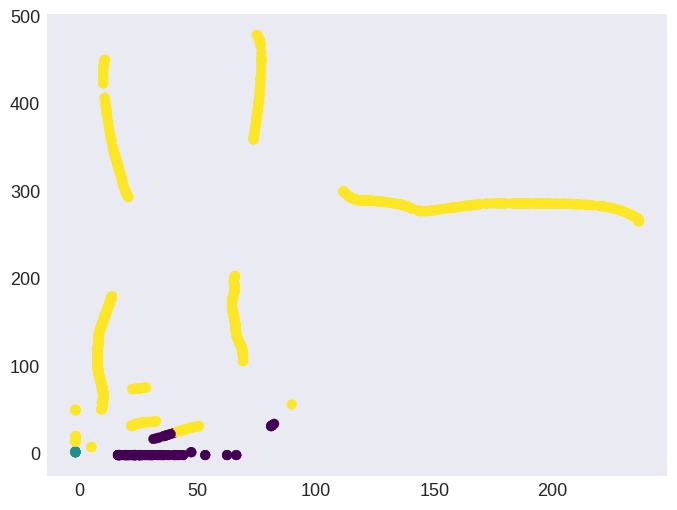

In [ ]:
# plot the cluster assignments
plt.scatter(feature_arr[:, 0], feature_arr[:, 1], c=cluster_assignments)

In [ ]:
print(len(set(cluster_assignments)) - (1 if -1 in cluster_assignments else 0))

from load_data import parameters_dict, simulation_file_paths

import plotly.graph_objs as go
import plotly.express as ptx

class_dict = {f"Class {i}": list() for i in range(len(set(cluster_assignments)))}
class_dict["Outliers"] = list()
for index, path in enumerate(simulation_file_paths):
    class_ = cluster_assignments[index]
    if class_ == -1:
        class_dict["Outliers"].append(str(path))
    else:
        class_dict[f"Class {class_}"].append(str(path))

traces = list()
for class_id, colour in zip(class_dict, ptx.colors.qualitative.Dark24):
    traces.append(
        go.Scatter(
            x=[
                parameters_dict[f]["H"]
                for f in class_dict[class_id]
            ],
            y=[
                parameters_dict[f]["E"]
                for f in class_dict[class_id]
            ],
            mode="markers",
            name=class_id,
            opacity=0.7,
            marker=dict(
                size=11,
                color=colour,
            ),
        )
    )

fig = go.Figure(data=traces)
fig.update_layout(
    autosize=False,
    width=990,
    height=600,
    margin=dict(
        l=10,
        r=10,
        b=25,
        t=25,
    ),
    xaxis_title=r"$\mu_0 \mathbf{H} \text{ (T)}$",
    yaxis_title=r"$\Delta \text{E (J)}$",
)

3


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#2E91E5', 'size': 11},
              'mode': 'markers',
              'name': 'Class 0',
              'opacity': 0.7,
              'type': 'scatter',
              'x': [0.21342597313549733, 0.21342597313549733, 0.10404936148175352,
                    0.10404936148175352, 0.10404936148175352, 0.07527286362065425,
                    0.07527286362065425, 0.07527286362065425, 0.12314500844208708,
                    0.12314500844208708, 0.12314500844208708, 0.1200051235924728,
                    0.1200051235924728, 0.1200051235924728, 0.06415061172236722,
                    0.06415061172236722, 0.06415061172236722, 0.16233320056405595,
                    0.16233320056405595, 0.16233320056405595, 0.05767995912901584,
                    0.05767995912901584, 0.05767995912901584, 0.029335013094577887,
                    0.029335013094577887, 0.029335013094577887,
                    0.029335013094577887, 0.13930175741253814, 0.13930175741253814,
                    0.13930175741253814, 0.13930175741253814, 0.09896463765738081,
                    0.09896463765738081, 0.09896463765738081,
                    0.0045748663348678335, 0.0045748663348678335,
                    0.0045748663348678335, 0.0045748663348678335,
                    0.0049577451594033485, 0.0049577451594033485,
                    0.0049577451594033485, 0.0049577451594033485,
                    0.1847971783887045, 0.1847971783887045, 0.1847971783887045,
                    0.13120496795805647, 0.13120496795805647, 0.13120496795805647,
                    0.24692969305196932, 0.24692969305196932, 0.17335539617312118,
                    0.17335539617312118, 0.17335539617312118, 0.048397381135607716,
                    0.048397381135607716, 0.048397381135607716,
                    0.12152269818476434, 0.12152269818476434, 0.12152269818476434,
                    0.16160298068677026, 0.16160298068677026, 0.16160298068677026,
                    0.2184194658900835, 0.2184194658900835, 0.20561918789003553,
                    0.20561918789003553, 0.09520598533519938, 0.09520598533519938,
                    0.09520598533519938, 0.10862032555585044, 0.10862032555585044,
                    0.10862032555585044, 0.12024626663464288, 0.12024626663464288,
                    0.12024626663464288, 0.05556525292833445, 0.05556525292833445,
                    0.05556525292833445, 0.020055601051892014,
                    0.020055601051892014, 0.020055601051892014,
                    0.020055601051892014, 0.012202489987678432,
                    0.012202489987678432, 0.012202489987678432,
                    0.012202489987678432, 0.20512440864035072, 0.20512440864035072,
                    0.2448758754028829, 0.2448758754028829, 0.195629753846063,
                    0.195629753846063, 0.01842989869844196, 0.01842989869844196,
                    0.01842989869844196, 0.01842989869844196, 0.0680853551098887,
                    0.0680853551098887, 0.0680853551098887, 0.09343237728599144,
                    0.09343237728599144, 0.09343237728599144, 0.1290774946406727,
                    0.1290774946406727, 0.1290774946406727, 0.12282567902694742,
                    0.12282567902694742, 0.12282567902694742, 0.10628000491945659,
                    0.10628000491945659, 0.10628000491945659, 0.013790040024915795,
                    0.013790040024915795, 0.013790040024915795,
                    0.013790040024915795, 0.10282549835843335, 0.10282549835843335,
                    0.10282549835843335, 0.1467594265549136, 0.1467594265549136,
                    0.1467594265549136, 0.15679231120900416, 0.15679231120900416,
                    0.15679231120900416, 0.1796772163756774, 0.1796772163756774,
                    0.1796772163756774, 0.1511396584396841, 0.1511396584396841,
                    0.1511396584396841, 0.15675005568735337, 0.15675005568735337,
                    0.15675005568735337, 0.104560520146578, 0.1045

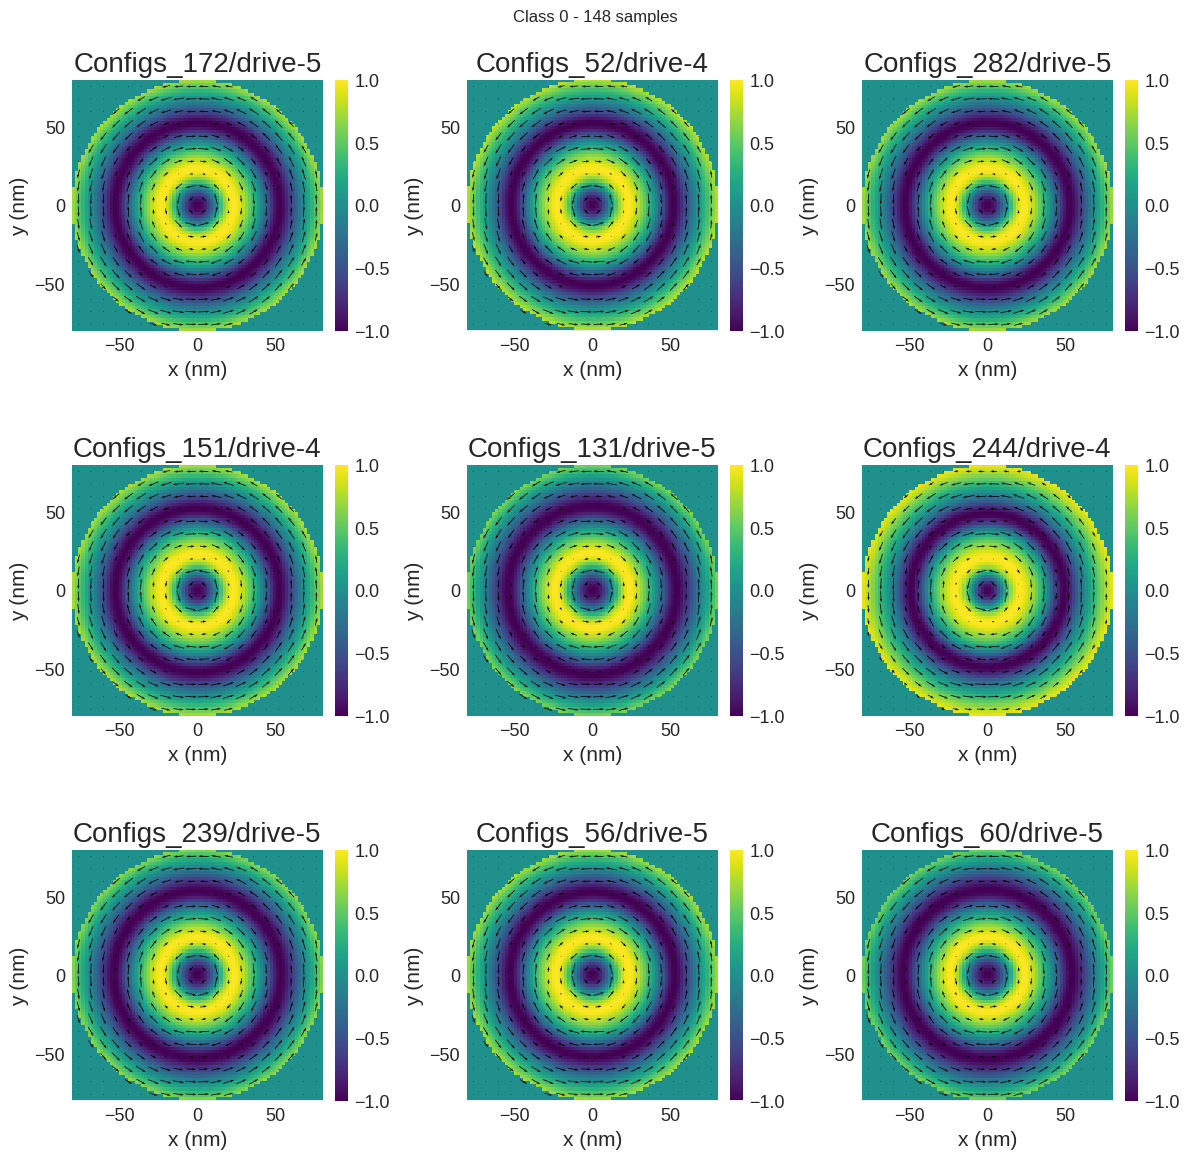

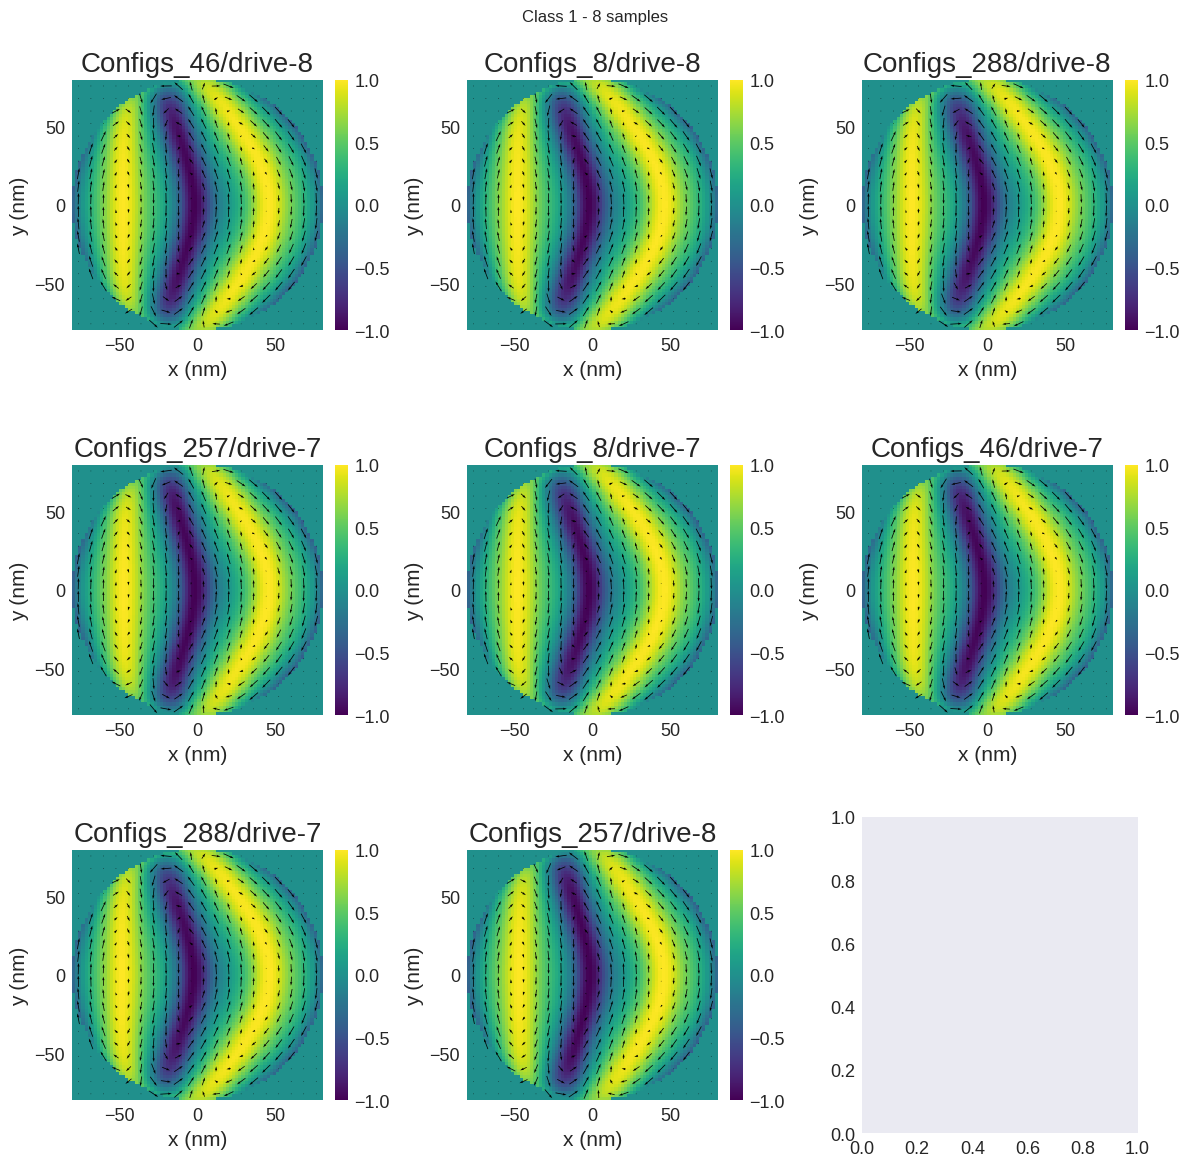

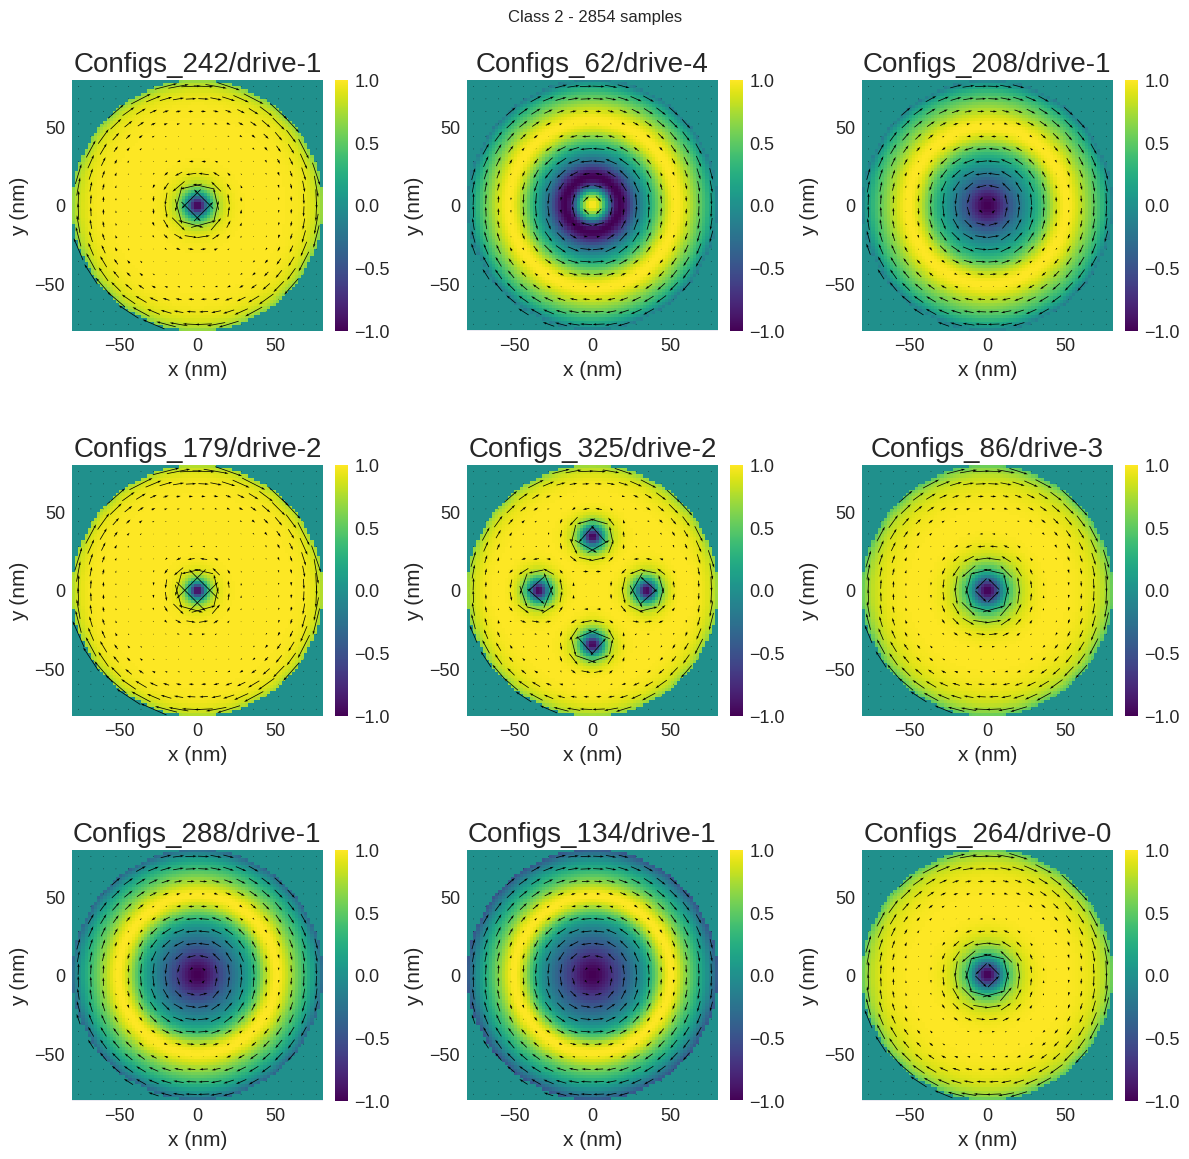

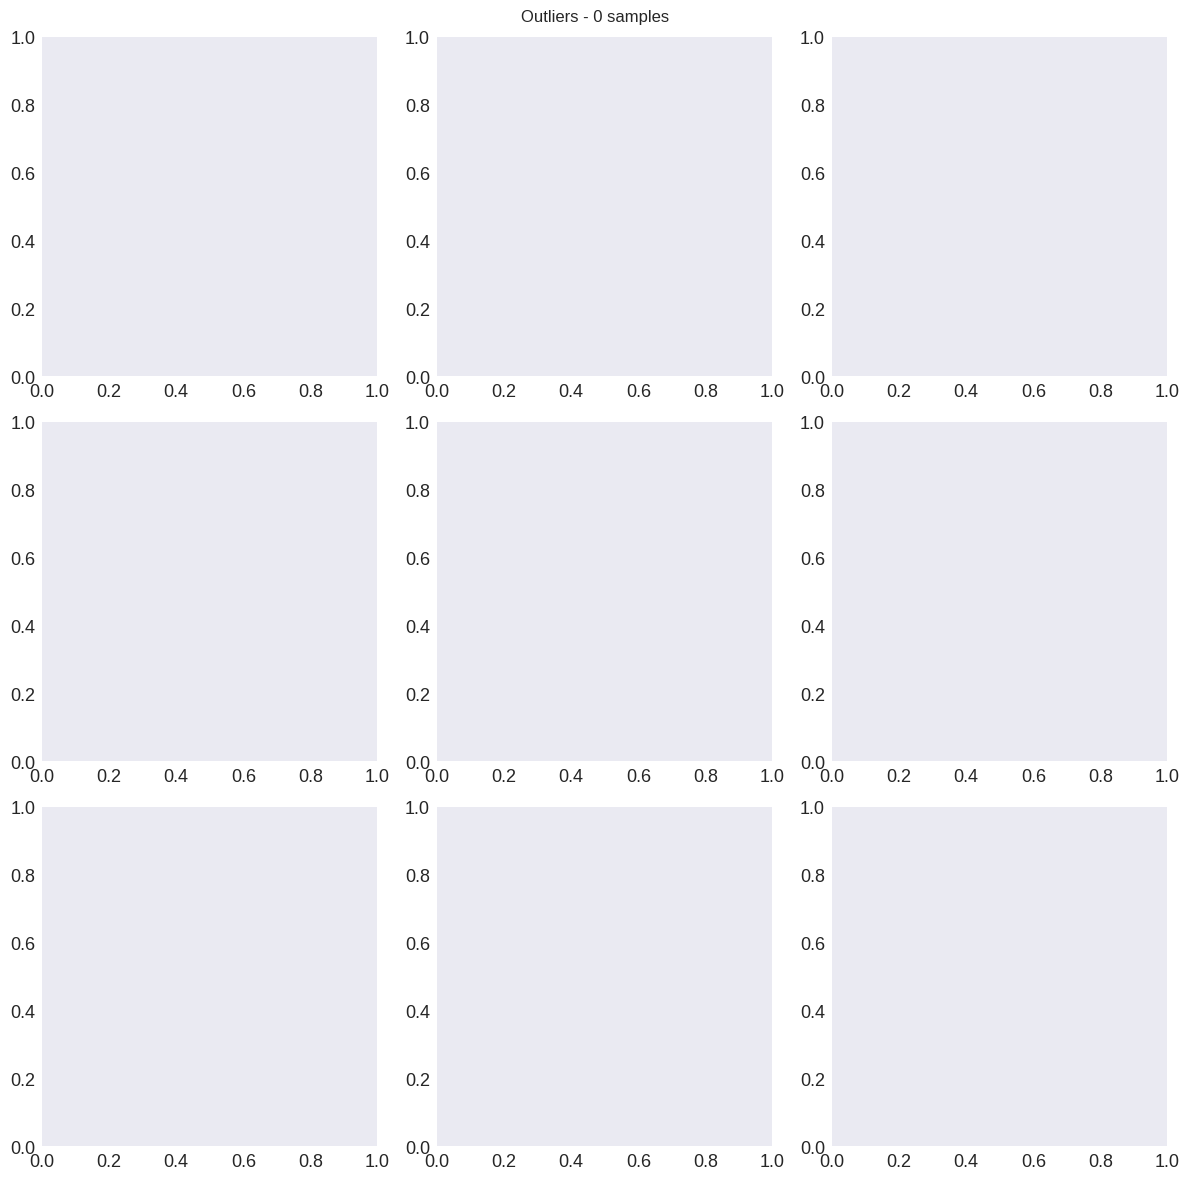

In [ ]:
from plotting import plot_all_examples

plot_all_examples(class_dict, parameters_dict)